In [3]:
# pip install networkx 
# pip install pyproj

import pandas as pd
import numpy as np
import csv
import math
import networkx as nx 

#Widget
import ipywidgets as widgets
from IPython.display import display

#Map interactive
import folium as f
from folium.plugins import MarkerCluster

#Map pour connection
import matplotlib.pyplot as plt
%matplotlib inline

#Calcul great circle
import pyproj


#import os
#import flightradar24

## Regles de codage 


In [4]:
'''
type_nom_variable
nomFonction(nom_variable : type) 
\'''
    description
    retour :  avec un exemple de forme 
\'''

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

'''

"\ntype_nom_variable\nnomFonction(nom_variable : type) \n'''\n    description\n    retour :  avec un exemple de forme \n'''\n\naeroport ipv airports \nvol --> routesANLO --> df_vols\nroutes --> dict_routes \n\n"

## Importation des données

In [5]:
chemin="../data/"

#df_aeroports = pd.read_csv(chemin + "aeroportsANLO.csv")
#df_zones = pd.read_csv(chemin + "zonesANLO.csv")
df_vols = pd.read_csv(chemin + "routesANLO.csv")
#df_compagnies = pd.read_csv(chemin + "compagniesANLO.csv")

In [14]:
dict_compagnies = {}

with open(chemin+'compagniesANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    next(reader, None)
    headers = ['Name','Country']
    dict_compagnies = {rows[2]:dict(zip(headers,[rows[0],rows[3]])) for rows in reader}


In [7]:
dict_aeroports = {}

with open(chemin+'aeroportsANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_aeroports = {rows[1]:dict(zip(headers,rows[0:8])) for rows in reader}

dict_aeroports['CDG']

{'Name': 'Paris Charles de Gaulle Airport',
 'Iata': 'CDG',
 'Icao': 'LFPG',
 'Lat': '49.012516',
 'Lon': '2.555752',
 'Country': 'France',
 'Alt': '392',
 'City': 'Paris'}

In [8]:
dict_pays = {}

with open(chemin+'countries.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_pays = {rows[1]:rows[0] for rows in reader}

dict_pays

{'Algeria': 'Africa',
 'Angola': 'Africa',
 'Benin': 'Africa',
 'Botswana': 'Africa',
 'Burkina Faso': 'Africa',
 'Burundi': 'Africa',
 'Cameroon': 'Africa',
 'Cape Verde': 'Africa',
 'Central African Republic': 'Africa',
 'Chad': 'Africa',
 'Comoros': 'Africa',
 'Congo': 'Africa',
 'Democratic Republic Of The Congo': 'Africa',
 'Djibouti': 'Africa',
 'Egypt': 'Africa',
 'Equatorial Guinea': 'Africa',
 'Eritrea': 'Africa',
 'Ethiopia': 'Africa',
 'Gabon': 'Africa',
 'Gambia': 'Africa',
 'Ghana': 'Africa',
 'Guinea': 'Africa',
 'Guinea-Bissau': 'Africa',
 "Cote D'ivoire (Ivory Coast)": 'Africa',
 'Kenya': 'Africa',
 'Lesotho': 'Africa',
 'Liberia': 'Africa',
 'Libya': 'Africa',
 'Madagascar': 'Africa',
 'Malawi': 'Africa',
 'Mali': 'Africa',
 'Mauritania': 'Africa',
 'Mauritius': 'Africa',
 'Morocco': 'Africa',
 'Mozambique': 'Africa',
 'Namibia': 'Africa',
 'Niger': 'Africa',
 'Nigeria': 'Africa',
 'Rwanda': 'Africa',
 'Sao Tome And Principe': 'Africa',
 'Senegal': 'Africa',
 'Seychell

In [9]:
df_vols = df_vols[["Depart","Arrivee","Code_ICAO"]].dropna()

In [10]:
#Nettoyage de la df_vols
for _, ligne in df_vols.iterrows():
    if not(ligne.Depart in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Depart'] == ligne.Depart].index, inplace=True)
    
    if not(ligne.Arrivee in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Arrivee'] == ligne.Arrivee].index, inplace=True)

In [11]:
def coordDepuisAeroport(iata : str):
    '''
    Fonction : Recherche les coordonnées GPS d'un aéroport
    Retour : lat : float ,lon : float --> Latitude & longitude de l'aéroport
    '''
    lat = float(dict_aeroports[iata]['Lat'])
    lon = float(dict_aeroports[iata]['Lon'])
    return lat,lon

def DistGrandCercle(lat1 : float, lon1 : float, lat2 : float, lon2 : float):
    #Conversion en radian
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    #Delta des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #Rayon terrestre (en km)
    r = 6367.0

    #Formule d'Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * r * math.asin(math.sqrt(a))


def DistGrandCercleICAO(icao1 : str, icao2 : str):
    #Récupération des coordonnées des aéroports
    latDep, lonDep = coordDepuisAeroport(icao1)
    latArr, lonArr = coordDepuisAeroport(icao2)

    #On calcule la distance les séparant,                                                     
    return DistGrandCercle(latDep,lonDep,latArr,lonArr)

In [12]:
dict_route = {}

g = df_vols.groupby(['Depart','Arrivee'])
taille_groupe = g.size().items()

for liaison, nbrVols in taille_groupe:
    #Si la liaison est déjà dans le dict, on incrémente le nbr de vols
    if(frozenset(liaison) in dict_route):
        dict_route[frozenset(liaison)]['Vols'] += nbrVols
    #Sinon, on crée une nouvelle liaison
    else:
        dict_route[frozenset(liaison)] = {'Dist' : DistGrandCercleICAO(liaison[0],liaison[1]), 'Vols' : nbrVols}

#Exemple :
dict_route[frozenset(('CDG','SIN'))]

{'Dist': 10717.48589664754, 'Vols': 5}

In [13]:
def filtreDictAeroports(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des aéroports
    '''
    Listtmp = []
    for (key, value) in dict_aeroports.items():
        if value[colonne] == valeur:
            Listtmp.append(key)
    return Listtmp

def filtreDictCompagnies(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des compagnies
    '''
    Listtmp = []
    for (key, value) in dict_compagnies .items():
        if value[colonne] == valeur:
            Listtmp.append(key)
    return Listtmp

# Fonctions -- Correspondance 

In [17]:
def correspondance_1airport_int(code1 : str, code2 : str):
    r1 = df_vols[df_vols['Depart'] == code1]['Arrivee'].to_list()
    r2 = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

In [22]:
def creation_edges(graphe : nx.Graph, listReference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    listConnections = correspondance_1airport_int(code1, code2)
    # pour gerer les correspondances 
    if listReference.count(code1) == 0: listReference.append(code1); 
    if listReference.count(code2) == 0: listReference.append(code2)
    
    for i in listConnections :
        if listReference.count(i) == 0 : 
            listReference.append(i)     
    
    index1 = listReference.index(code1) 
    index2 = listReference.index(code2)
    weight = 2  # TODO calculer le C02 par rapport a la distance  
   
    listEdges = list(map(lambda x : (index1, listReference.index(x), weight), listConnections))
    listEdges.extend(list(map(lambda y : (listReference.index(y), index2, weight), listConnections)))
    
    graphe.add_weighted_edges_from(listEdges)
    return listEdges

In [23]:
def dessiner_graphe(nom_graphe):
 
    pos = nx.fruchterman_reingold_layout(nom_graphe)
    nx.draw_networkx_nodes(nom_graphe, pos, node_size = 200)
    nx.draw_networkx_edges(nom_graphe,pos, edgelist= nom_graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(nom_graphe, pos)
    plt.autoscale()
    #plt.title((code1,code2))
    #nx.draw_networkx_edge_labels(nom_graphe, pos) # afficher le weight 

    plt.show()

In [24]:
def conversion(listOfEdgesWeighted : list[tuple], graphe : nx.Graph):
    '''
        function qui convertie un list avec les edges d'uin graph avec leur "weight" et 
        qui le convertie en une dict de graph qui peut être utilise par le algorithme de dijkstra 
        retour : le dict qui represente une graphe sous forme de { ind_start : [(end, weight) , (end, weight)], ind_start : [ ..] etc }
    '''
    # calculer le nombre de nodes 
    nbNodes = graphe.number_of_nodes()
    
    # creation d'une dict avec le nombre de nodes initialise avec une liste vide 
    returnDict= dict()
    
    for i in range(0,nbNodes):         
        returnDict[i] = []

    # remplir le dictionairy a partir de listOfEdgesWeighted
    for t in listOfEdgesWeighted:
        # on doit ajoute les edges dans les deux cote (de 1 --> 2 et de 2 --> 1)
        returnDict[t[0]].append((t[1],t[2])) 
        returnDict[t[1]].append((t[0],t[2])) 
        
    return returnDict

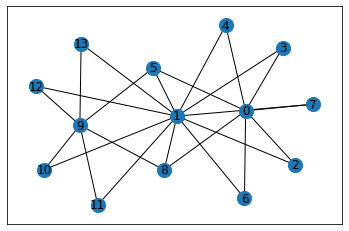

In [26]:
graph_test4_2 = nx.Graph(); 
ref_test4_2 = []

# creer une correspondance 
test_time2 = creation_edges(graph_test4_2, ref_test4_2, 'AAR', 'DUS')
test_time2.extend(creation_edges(graph_test4_2, ref_test4_2, 'DUS', 'ANR'))

dessiner_graphe(graph_test4_2)